In [1]:
import pandas as pd
import numpy as np


train = pd.read_json('data/train.json')
test = pd.read_json('data/test.json')

print(train.shape)
print(train.head())

print(test.shape)
print(test.head())

(1604, 5)
                                              band_1  \
0  [-27.878360999999998, -27.15416, -28.668615, -...   
1  [-12.242375, -14.920304999999999, -14.920363, ...   
2  [-24.603676, -24.603714, -24.871029, -23.15277...   
3  [-22.454607, -23.082819, -23.998013, -23.99805...   
4  [-26.006956, -23.164886, -23.164886, -26.89116...   

                                              band_2        id inc_angle  \
0  [-27.154118, -29.537888, -31.0306, -32.190483,...  dfd5f913   43.9239   
1  [-31.506321, -27.984554, -26.645678, -23.76760...  e25388fd   38.1562   
2  [-24.870956, -24.092632, -20.653963, -19.41104...  58b2aaa0   45.2859   
3  [-27.889421, -27.519794, -27.165262, -29.10350...  4cfc3a18   43.8306   
4  [-27.206915, -30.259186, -30.259186, -23.16495...  271f93f4   35.6256   

   is_iceberg  
0           0  
1           0  
2           1  
3           0  
4           0  
(8424, 4)
                                              band_1  \
0  [-15.863251, -15.201077, -17.88

In [2]:
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75)
                   for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) 
                   for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], ((X_band_1+X_band_2)/2)[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis]], axis=-1)
print(X_band_1.shape)
print(X_band_2.shape)
print(X_train.shape)

(1604, 75, 75)
(1604, 75, 75)
(1604, 75, 75, 3)


In [4]:
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)

X_angle_train = np.array(train.inc_angle)
X_angle_test = np.array(test.inc_angle)
print(X_angle_train.shape)

(1604,)


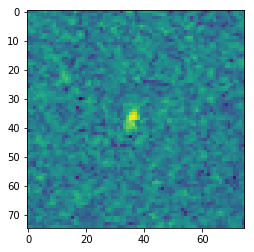

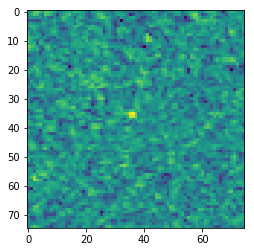

In [152]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(X_band_1[2])
plt.show()
plt.figure()
plt.imshow(X_band_2[2])
plt.show()

In [153]:
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(X_band_1[12,:,:], 'iceberg')

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers.merge import Concatenate
from keras.models import Model

def getModel():
    bn_model = 0
    p_activation = "elu"
    input_1 = Input(shape=(75, 75, 3), name="X_1")
    input_2 = Input(shape=[1], name="angle")
    
    img_1 = Conv2D(16, kernel_size = (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(input_1))
    img_1 = Conv2D(16, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(128, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = GlobalMaxPooling2D() (img_1)
    
    '''
    img_2 = Conv2D(128, kernel_size = (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(input_1))
    img_2 = MaxPooling2D((2,2)) (img_2)
    img_2 = Dropout(0.2)(img_2)
    img_2 = GlobalMaxPooling2D() (img_2)
    '''
    img_concat =  (Concatenate()([img_1, BatchNormalization(momentum=bn_model)(input_2)]))
    
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(256, activation=p_activation)(img_concat) ))
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(64, activation=p_activation)(dense_ayer) ))
    output = Dense(1, activation="sigmoid")(dense_ayer)
    
    model = Model([input_1,input_2],  output)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [14]:
model = getModel()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_1 (InputLayer)                (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 75, 75, 3)    12          X_1[0][0]                        
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 73, 73, 16)   448         batch_normalization_15[0][0]     
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 71, 71, 16)   2320        conv2d_36[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [15]:
def DataGen(X_train, y_train, batch_size):
    datagen = ImageDataGenerator(rescale=1. / 255,zoom_range=0.25, 
                             rotation_range=15.,channel_shift_range=25., 
                             width_shift_range=0.02, height_shift_range=0.02,
                             horizontal_flip=True, vertical_flip = True, fill_mode='constant')
    generator = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
    return generator

In [22]:
from sklearn.model_selection import train_test_split

image_size = 75
batch_size = 64

y_train=train['is_iceberg']
X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train
                    , X_angle_train, y_train, random_state=123, train_size=0.75)

# Generate data
trn_generator = DataGen(X_train_cv, y_train_cv, batch_size)
val_generator = DataGen(X_valid, y_valid, batch_size)

C:\Users\septe\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [23]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]


file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

model = getModel()
model.fit([X_train, X_angle_train], y_train, epochs=25
          , validation_data=([X_valid, X_angle_valid], y_valid)
         , batch_size=32
         , callbacks=callbacks)

Train on 1203 samples, validate on 401 samples
Epoch 1/25
1203/1203 [==============================] - 29s 24ms/step - loss: 0.7933 - acc: 0.6076 - val_loss: 0.6865 - val_acc: 0.7107
Epoch 2/25
1203/1203 [==============================] - 24s 20ms/step - loss: 0.5545 - acc: 0.7423 - val_loss: 0.3805 - val_acc: 0.8105
Epoch 3/25
1203/1203 [==============================] - 24s 20ms/step - loss: 0.4458 - acc: 0.8022 - val_loss: 0.7006 - val_acc: 0.7332
Epoch 4/25
1203/1203 [==============================] - 24s 20ms/step - loss: 0.5091 - acc: 0.7648 - val_loss: 0.3583 - val_acc: 0.8529
Epoch 5/25
1203/1203 [==============================] - 25s 20ms/step - loss: 0.3945 - acc: 0.8246 - val_loss: 0.4033 - val_acc: 0.8454
Epoch 6/25
1203/1203 [==============================] - 25s 21ms/step - loss: 0.3820 - acc: 0.8130 - val_loss: 0.4585 - val_acc: 0.8105
Epoch 7/25
1203/1203 [==============================] - 24s 20ms/step - loss: 0.3662 - acc: 0.8396 - val_loss: 0.3728 - val_acc: 0.8554
E

In [ ]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)
predicted_test=gmodel.predict_proba(X_test)

In [ ]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)